# Naive Discriminant Analysis on Portuguese Banking Institution Data

This notebook implements and compares discriminant analysis methods on a banking dataset (read from `banking.csv`). In particular, we address the following:

1. **(a) Quadratic Discriminant Analysis (QDA):**  
   We assume that the class-conditional densities are multivariate Gaussian with different covariance matrices $\Sigma_k$. We derive the discriminant functions and decision boundary.

2. **(b) Naive Bayes (NB) Classifier:**  
   We show that if we assume the covariance matrices are diagonal (i.e. features are conditionally independent), then the LDA classifier (or in this case, the Gaussian model) reduces to a Naive Bayes classifier. We state the corresponding discriminant functions and decision boundaries.

3. **(c) Implementation of the NB Classifier:**  
   We implement a custom NB classifier as a scikit-learn predictor class.

4. **(d) Data Loading and Train/Test Split:**  
   We read the dataset `banking.csv` and create training and testing sets. We stratify the split on the target variable to maintain the class distribution.

5. **(e) Data Processing Pipeline:**  
   We build a pipeline using scikit-learn’s `Transformer` classes (e.g., `SimpleImputer`, `OneHotEncoder`, `StandardScaler`) and the `ColumnTransformer` to process numerical and categorical features.

6. **(f) Model Fitting and Comparison:**  
   We fit both the built-in LDA classifier and our custom NB classifier to predict the target variable and compare their accuracies.

7. **(g) Appropriateness of the NB Classifier:**  
   We discuss whether the NB classifier is appropriate for this dataset by comparing performance and checking for feature correlations.
   

## (c) Implementation of the NB Classifier as a scikit-learn Predictor

Below is the implementation of a Gaussian Naive Bayes classifier assuming conditional independence. We implement it as a scikit-learn estimator by inheriting from `BaseEstimator` and `ClassifierMixin`.

For the _log_likelihood() function, mathmatical expression derived before is: 
$$
\log p\left(\mathbf{x} \mid C_k\right)=-\frac{1}{2} \sum_{s=1}^S \log \left(2 \pi \sigma_{k s}^2\right)-\frac{1}{2} \sum_{s=1}^S \frac{\left(x_s-\mu_{k s}\right)^2}{\sigma_{k s}^2} .
$$

For the predict_log_prob() function, we are using:
$$
\log p\left(C_k \mid \mathbf{x}\right) \propto \log \pi_k+\log p\left(\mathbf{x} \mid C_k\right)=\log \pi_k-\frac{1}{2} \sum_{s=1}^S\left[\log \left(2 \pi \sigma_{k s}^2\right)+\frac{\left(x_s-\mu_{k s}\right)^2}{\sigma_{k s}^2}\right]
$$

For the predict() function as our final class prediction, we are using: 
$$
\hat{k}=\arg \max _k\left(\log \pi_k+\sum_{s=1}^S \log p\left(x_s \mid C_k\right)\right)
$$

For the predict_prob() function as our predicted class probabilities, we are using Softmax Transformation with numerical stability adjustments:
$$
p\left(C_k \mid \mathbf{x}\right)=\frac{\exp \left(z_k(\mathbf{x})-M(\mathbf{x})\right)}{\sum_{j=1}^K \exp \left(z_j(\mathbf{x})-M(\mathbf{x})\right)},
$$
with
$$
z_k(\mathbf{x})=\log \pi_k+\log p\left(\mathbf{x} \mid C_k\right), \quad M(\mathbf{x})=\max _{1 \leq j \leq K} z_j(\mathbf{x})
$$

In [1]:
# Naive Bayes Classifier

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        """
        Fit the Naive Bayes model.
        Parameters:
          X : array-like, shape (n_samples, n_features)
              Training data.
          y : array-like, shape (n_samples,)
              Target labels.
        """
        self.classes_ = np.unique(y) # Binary classification
        n_features = X.shape[1]
        self.priors_ = {}
        self.means_ = {}
        self.vars_ = {}  

        for cls in self.classes_:
            X_cls = X[y == cls]
            self.priors_[cls] = X_cls.shape[0] / X.shape[0]
            self.means_[cls] = np.mean(X_cls, axis=0)
            # Add a small epsilon to avoid division by zero
            self.vars_[cls] = np.var(X_cls, axis=0) + 1e-9
        print(self.priors_)
        return self

    def _log_likelihood(self, X, cls):
        """
        Compute the log likelihood of data X under class cls.
        """
        mean = self.means_[cls]
        var = self.vars_[cls]
        # Compute the log probability of the Gaussian distribution for each feature
        log_prob = -0.5 * np.sum(np.log(2 * np.pi * var)) + -0.5 * np.sum(((X - mean) ** 2) / var, axis=1)
        return log_prob

    def predict_log_prob(self, X):
        """
        Compute the unnormalized log posterior probabilities for each class.
        """
        predict_log_prob = []
        for cls in self.classes_:
            log_prior = np.log(self.priors_[cls])
            log_likelihood = self._log_likelihood(X, cls)
            predict_log_prob.append(log_prior + log_likelihood)
        return np.column_stack(predict_log_prob)

    def predict(self, X):
        """
        Predict class labels for samples in X.
        """
        log_prob = self.predict_log_prob(X)
        indices = np.argmax(log_prob, axis=1)
        return self.classes_[indices]

    def predict_prob(self, X):
        """
        Predict class probabilities for samples in X.
        """
        log_prob = self.predict_log_prob(X)
        # To avoid numerical overflow, subtract the max log probability for each sample.
        max_log = np.max(log_prob, axis=1, keepdims=True)
        prob = np.exp(log_prob - max_log) / np.sum(prob, axis=1, keepdims=True)
        return prob


## (d) Data Loading and Train/Test Split

In this section we read the CSV file `banking.csv` and create the training and testing sets.  

**Note on stratification:**  
Since {0: 0.8873434844438278, 1: 0.11265651555617218} represents the prior distribution of each class on our target `y`, we can see that they are very imbalanced. So it is crucial to stratify on `y` so that the training and test sets can be split closer to the prior distribution. In practice, stratifying on the target variable is often sufficient and it is not always necessary or beneficial since stratifying on too many features can lead to very small subgroups and unstable splits, which might harm rather than help model training and evaluation. 


In [2]:
## Data Loading and Train/Test Split

import pandas as pd
from sklearn.model_selection import train_test_split

# Read the CSV file. Make sure the 'banking.csv' file is in your working directory.
df = pd.read_csv('banking.csv')

# Display the first few rows to check the data format
print(df.head())

# The target variable is the column 'y'
X = df.drop('y', axis=1)
y = df['y']

# Split the data with stratification on y to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.3
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


   age          job  marital          education  default housing loan  \
0   44  blue-collar  married           basic.4y  unknown     yes   no   
1   53   technician  married            unknown       no      no   no   
2   28   management   single  university.degree       no     yes   no   
3   39     services  married        high.school       no      no   no   
4   55      retired  married           basic.4y       no     yes   no   

    contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0  cellular   aug         thu  ...         1    999         0  nonexistent   
1  cellular   nov         fri  ...         1    999         0  nonexistent   
2  cellular   jun         thu  ...         3      6         2      success   
3  cellular   apr         fri  ...         2    999         0  nonexistent   
4  cellular   aug         fri  ...         1      3         1      success   

  emp_var_rate  cons_price_idx  cons_conf_idx  euribor3m  nr_employed  y  
0          1.4   

## (e) Data Processing Pipeline

We now build a data processing pipeline to prepare the data before classification. In this dataset, some columns are numeric (e.g., `age`, `duration`, `campaign`, etc.) and others are categorical (e.g., `job`, `marital`, `education`, etc.).

The pipeline will consist of the following steps:
1. **Imputation:** Fill in missing values using `SimpleImputer`.
2. **Categorical Encoding:** Convert categorical variables into dummy/one-hot variables using `OneHotEncoder`.
3. **Feature Scaling:** Standardize numerical features using `StandardScaler`.

We use `ColumnTransformer` to apply different transformations to numeric and categorical features, and then integrate everything into a `Pipeline`.


In [3]:
# Data Processing Pipeline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identify numeric and categorical features
numeric_features = ['age', 'duration', 'campaign', 'pdays', 'previous',
                    'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
                    'euribor3m', 'nr_employed']
categorical_features = ['job', 'marital', 'education', 'default', 'housing',
                        'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# Pipeline for numerical features: imputation + scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features: imputation + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


## (f) Model Fitting and Comparison

We now build two complete pipelines:
- One for the built-in LDA classifier (from scikit-learn)
- One for our custom NB classifier (implemented above)

We then fit both models on the training set and compare their accuracy on the test set, which is calculated as: 

$$
\text { Accuracy }=\frac{\text { \# Correctly labeled sample }}{\text { \# Total sample }}
$$


In [4]:
# Comparison Between LDA and NB Classifiers

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

# Pipeline with preprocessor and LDA classifier
pipeline_lda = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearDiscriminantAnalysis())
])

# Pipeline with preprocessor and NB classifier
pipeline_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', NaiveBayes())
])

# Fit LDA pipeline
pipeline_lda.fit(X_train, y_train)
y_pred_lda = pipeline_lda.predict(X_test)
acc_lda = accuracy_score(y_test, y_pred_lda)
print("LDA Classifier Accuracy:", acc_lda)
print("LDA Classification Report:")
print(classification_report(y_test, y_pred_lda))

# Fit Naive Bayes pipeline
pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Classifier Accuracy:", acc_nb)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


LDA Classifier Accuracy: 0.9113862588006798
LDA Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10965
           1       0.63      0.51      0.56      1392

    accuracy                           0.91     12357
   macro avg       0.79      0.74      0.76     12357
weighted avg       0.90      0.91      0.91     12357

{0: 0.8873434844438278, 1: 0.11265651555617218}
Naive Bayes Classifier Accuracy: 0.8123330905559601
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     10965
           1       0.33      0.66      0.44      1392

    accuracy                           0.81     12357
   macro avg       0.64      0.75      0.66     12357
weighted avg       0.88      0.81      0.84     12357



## (g) Appropriateness of the NB Classifier for This Dataset

We can see that in our case, LDA does better than NB. The reason behind can be that the Naive Bayes classifier assumes that the features are conditionally independent given the class. In our real-world banking dataset, it is likely that some features are correlated (for example, financial indices or customer attributes may be related). Therefore we can compute the correlation matrix of the numeric features to see if there are any strong correlations among them.



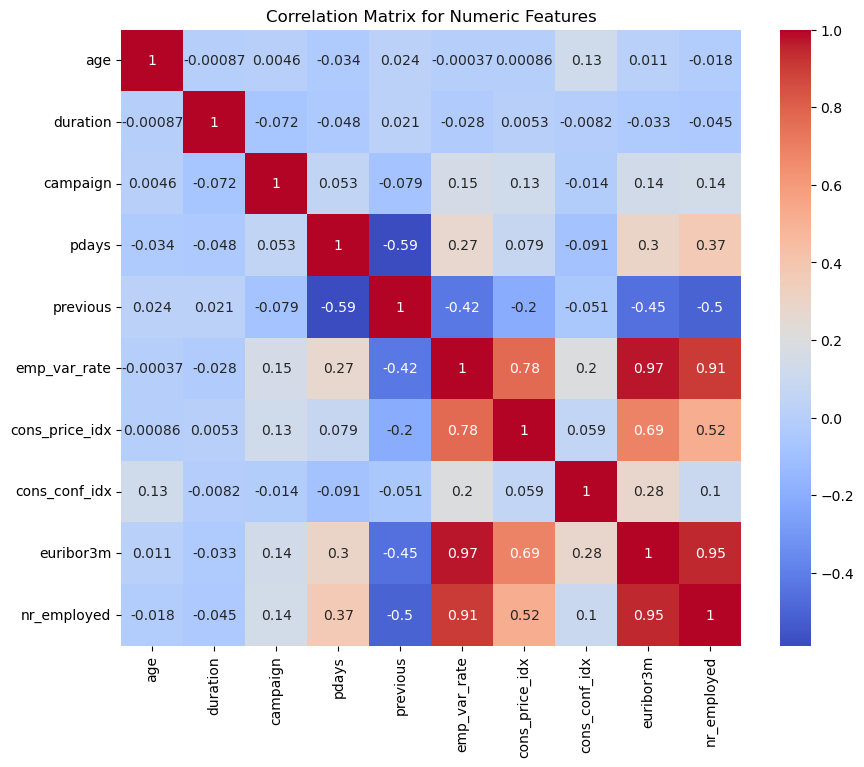

In [5]:
# Correlation Analysis of Numeric Features

import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features from the original dataframe
numeric_df = df[numeric_features]
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()


### Conclusion for Part (g)

We can see that there are bunch of strong correlations among features, for instance, the strong positive correlation between `emp_var_rate`(employment variation rate) and `euribor3m`(3 months Euribor rate) & `nr_employed`(number of employees) & `cons_price_idx`(Consumer price index), or the strong negative correlation between `previous` and `pdays`, etc. Therefore the conditional independence assumption in NB classifier is likely violated, causing the NB classifier performs worse than the LDA classifier. Also, as LDA outperforms NB, it indicates that modeling the full covariance structure (as in LDA) captures important relationships among the features that the NB classifier ignores. 

---

## Final Remarks

This notebook demonstrates how to implement LDA and Naive Bayes classifier on the `Portuguese Banking Instution Dataset` by building data processing pipelines in scikit-learn. It also shows how to compare model performance and analyze whether the assumptions behind a model are appropriate for the dataset. As the observations in Part(g), we may consider using PCA or other dimension-reduction methods for better performance. 
